# ELE 435/535 LAB 5: Small Datasets, Overfitting, and Null Tests

## Enrollment: 535
## Name: Prerit Terway

When you have a small dataset it is imporant to realize that a trained classifier may fit random noise yet give an accuracy better than chance on the test set. The more complex the classifer the greater the chance that this will happen.

This lab illustrates this effect using syhthetic data drawn from a multivariate Gaussian density for which you can set the parameters. In particular, we use the synthetic data twice. 

(1) We generate synthetic data of k points for each of two classes. The data for each class has zero mean and the same covariance matrix. Since it is Gaussian, it is thus statistically identical. But of course due the random nature of the generator, the data for each class is different. We then fit and test a selected classifer to this **null data**. 

(2) Now we add a mean mu0 to the data for class 0, and a distinct mean mu1 to class 1. Then fit and test the same classifer to this true data.  

(3) We repeat steps (1) and (2) for repeated trials and average the test accruacies to get a mean performance and the standard deviation about the mean.

(4) Now repeat the loop in step (3) for k = k0, k0+10, ..., kmax.

This will take some time to compute. So while writing and testing the code select 50 trials , kmax = 50. When the code is working well, select larger values (say 500, or 1000 trials), and you can explore a larger range for k. 

In [28]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import random as rnd
from numpy import linalg as la
from scipy.stats import ortho_group

from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

%matplotlib inline

### 1) Generate Gaussian Data

**This part is already done to give you some idea on how to generate a synthetic Gaussian data.**

Q:
 [[ 0.66293557  0.74867645]
 [ 0.74867645 -0.66293557]]
Sigma:
 [[ 0.78025822 -0.24816213]
 [-0.24816213  0.71974178]]


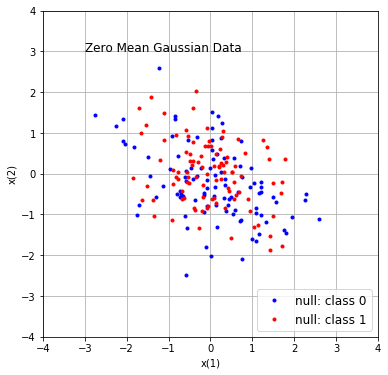

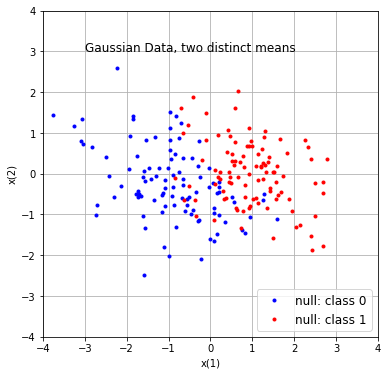

In [29]:
# Assign basic parameters
d = 2 #don't change this as we need to plot the points in 2D 
Sig = np.zeros((2,2))
# you can change these values
Sig[0,0] = 0.5
Sig[1,1] = 1.0

# how many points (examples)
# change this to see what happens
num_points = 100

# generate the data
Q = ortho_group.rvs(dim=d)           # random orthogonal matrix
Sigma = np.dot(np.dot(Q,Sig),Q.T)    # Covarance matrix

print('Q:\n',Q)
print('Sigma:\n', Sigma)

X0_train_null = np.random.multivariate_normal(np.zeros(d), Sigma, num_points)
X1_train_null = np.random.multivariate_normal(np.zeros(d), Sigma, num_points)
# These can be stacked together
X_train_null = np.vstack((X0_train_null, X1_train_null))

plt.figure(figsize=(6,6))
plt.plot(X0_train_null[:,0],X0_train_null[:,1], 'b.', label='null: class 0')
plt.plot(X1_train_null[:,0],X1_train_null[:,1], 'r.', label='null: class 1')
plt.grid(True)
plt.xlabel('x(1)')
plt.ylabel('x(2)')
plt.text(-3,3,'Zero Mean Gaussian Data', fontsize=12)
plt.axis(xmin=-4, xmax=4, ymin=-4, ymax=4)
plt.legend(loc=4, fontsize=12)
plt.show()

# True class data
# Add means
mu0 = -np.ones(d)
mu1 = np.ones(d)
X0_train = X0_train_null + mu0
X1_train = X1_train_null + mu1

plt.figure(figsize=(6,6))
plt.plot(X0_train[:,0],X0_train_null[:,1], 'b.', label='null: class 0')
plt.plot(X1_train[:,0],X1_train_null[:,1], 'r.', label='null: class 1')
plt.grid(True)
plt.xlabel('x(1)')
plt.ylabel('x(2)')
plt.text(-3,3,'Gaussian Data, two distinct means', fontsize=12)
plt.axis(xmin=-4, xmax=4, ymin=-4, ymax=4)
plt.legend(loc=4, fontsize=12)
plt.show()

### 2) Generate Data, Train Classifier, Record Results
You are going to generate examples and then use 5-fold cross-validation to train and test a classifier.
This is going to be repeated for many trials. For each trial you need to remember the test results. That way after the trials are finished you can compute a mean test accuracy the standard deviation over the trials. 

1. Generate a synthetic data from a 5 dimensional Gaussian density (this means each data point has 5 features, instead of 2 in previous example). Assign the means to class 0 ($\mu_{0}$) and class 1 ($\mu_{1}$) such that $\lvert \lvert \mu_{0} - \mu_{1} \rvert \rvert_2 = 1$. It is up to you how to do so.

2. Class 0 and class 1 are going to have the same covariance matrices. Further, use the following lines of code (in the next cell) to create your covariace matrix.

3. Now, pick the number of points in each class to be 10. Set the number of trials to be 50. This means you will repeat the same experiment 50 times and record the accuracies for the X_train_null and for the X_train; defined as:
        X_train_null = np.vstack((X0_train_null, X1_train_null))            
        X_train = np.vstack((X0_train_null+mu0, X1_train_null+mu1))

4. Now, train the following classifiers with 5-fold cross-validation and save the accuracies.

            i) Nearest centroid   ii) Gaussian Naive Bayes . iii) LDA  iiii) 3-nearest neighbor
    
                e.g.,
                     cross_val_score(clf_nc, X_train, y_train, cv=5)
                     cross_val_score(clf_nc, X_train_null, y_train, cv=5)

5. Repeat 3 for when the number of points in each class is 20, 30, 40,..., 100. 

In [30]:
mean_accuracy_null_nc = []
mean_variance_null_nc = []
mean_accuracy_train_nc = []
mean_variance_train_nc = []


mean_accuracy_null_nb = []
mean_variance_null_nb = []
mean_accuracy_train_nb = []
mean_variance_train_nb = []

mean_accuracy_null_lda = []
mean_variance_null_lda = []
mean_accuracy_train_lda = []
mean_variance_train_lda = []

mean_accuracy_null_nn = []
mean_variance_null_nn = []
mean_accuracy_train_nn = []
mean_variance_train_nn = []

for num_points in range(10,110,10):
    number_trials = 1000
    accuracy_null_nc = []
    accuracy_train_nc = []
    accuracy_null_nb = []
    accuracy_train_nb = []
    accuracy_null_lda = []
    accuracy_train_lda = []
    accuracy_null_nn = []
    accuracy_train_nn = []
    d = 5
    for j in range(0,number_trials):
        snr = 1.5
        sigma2 = (1/snr)**2
        Sig = np.zeros((5,5))
        for ii in range(0,5):
            Sig[ii,ii] = sigma2*(1+0.1*ii)
        Q = ortho_group.rvs(dim=5) #creating random orthogonal matrix
        Sigma = np.dot(np.dot(Q,Sig),Q.T)
        X0_train_null = np.random.multivariate_normal(np.zeros(5), Sigma, num_points)
        X1_train_null = np.random.multivariate_normal(np.zeros(5), Sigma, num_points)  


        #### My modification starts #####
        mu0 = -np.ones(d)*0
        mu1 = np.ones(d)/np.sqrt(5)
        X_train_null = np.vstack((X0_train_null, X1_train_null)) 
        X_train = np.vstack((X0_train_null+mu0, X1_train_null+mu1))

        ###### generate labels #########
        y0_train_null = np.zeros(num_points)
        y1_train_null = np.zeros(num_points) + 1
        y_train_null = np.hstack((y0_train_null,y1_train_null))
        y_train = np.hstack((y0_train_null,y1_train_null))
        ##############################################
        ########### Nearest Centroid ##############
        clf_nc = NearestCentroid()
        accuracy_null = cross_val_score(clf_nc, X_train_null, y_train_null, cv=5)
        accuracy_null_mean = np.mean(accuracy_null)
        accuracy_train = cross_val_score(clf_nc, X_train, y_train_null, cv=5)
        accuracy_train_mean = np.mean(accuracy_train)
        accuracy_null_nc.append(accuracy_null_mean)
        accuracy_train_nc.append(accuracy_train_mean)

        ########### GaussianNB ##############
        clf_nb = GaussianNB()
        accuracy_null = cross_val_score(clf_nb, X_train_null, y_train_null, cv=5)
        accuracy_null_mean = np.mean(accuracy_null)
        accuracy_train = cross_val_score(clf_nb, X_train, y_train_null, cv=5)
        accuracy_train_mean = np.mean(accuracy_train)
        accuracy_null_nb.append(accuracy_null_mean)
        accuracy_train_nb.append(accuracy_train_mean)

        ########### LDA ##############
        clf_lda = LinearDiscriminantAnalysis()
        accuracy_null = cross_val_score(clf_lda, X_train_null, y_train_null, cv=5)
        accuracy_null_mean = np.mean(accuracy_null)
        accuracy_train = cross_val_score(clf_lda, X_train, y_train_null, cv=5)
        accuracy_train_mean = np.mean(accuracy_train)
        accuracy_null_lda.append(accuracy_null_mean)
        accuracy_train_lda.append(accuracy_train_mean)

        ########### NN ##############
        clf_NN = KNeighborsClassifier(n_neighbors=3)
        accuracy_null = cross_val_score(clf_NN, X_train_null, y_train_null, cv=5)
        accuracy_null_mean = np.mean(accuracy_null)
        accuracy_train = cross_val_score(clf_NN, X_train, y_train_null, cv=5)
        accuracy_train_mean = np.mean(accuracy_train)
        accuracy_null_nn.append(accuracy_null_mean)
        accuracy_train_nn.append(accuracy_train_mean)
    
    accuracy_null_nc_mean =  np.mean(np.asarray(accuracy_null_nc))
    accuracy_train_nc_mean =  np.mean(np.asarray(accuracy_train_nc))
    accuracy_null_nc_var =  np.std(np.asarray(accuracy_null_nc))
    accuracy_train_nc_var =  np.std(np.asarray(accuracy_train_nc))    
    mean_accuracy_null_nc.append(accuracy_null_nc_mean)
    mean_variance_null_nc.append(accuracy_null_nc_var)
    mean_accuracy_train_nc.append(accuracy_train_nc_mean)
    mean_variance_train_nc.append(accuracy_train_nc_var)

    
    accuracy_null_nb_mean =  np.mean(np.asarray(accuracy_null_nb))
    accuracy_train_nb_mean =  np.mean(np.asarray(accuracy_train_nb))
    accuracy_null_nb_var =  np.std(np.asarray(accuracy_null_nb))
    accuracy_train_nb_var =  np.std(np.asarray(accuracy_train_nb))    
    mean_accuracy_null_nb.append(accuracy_null_nb_mean)
    mean_variance_null_nb.append(accuracy_null_nb_var)
    mean_accuracy_train_nb.append(accuracy_train_nb_mean)
    mean_variance_train_nb.append(accuracy_train_nb_var)
    

    
    accuracy_null_lda_mean =  np.mean(np.asarray(accuracy_null_lda))
    accuracy_train_lda_mean =  np.mean(np.asarray(accuracy_train_lda))
    accuracy_null_lda_var =  np.std(np.asarray(accuracy_null_lda))
    accuracy_train_lda_var =  np.std(np.asarray(accuracy_train_lda))    
    mean_accuracy_null_lda.append(accuracy_null_lda_mean)
    mean_variance_null_lda.append(accuracy_null_lda_var)
    mean_accuracy_train_lda.append(accuracy_train_lda_mean)
    mean_variance_train_lda.append(accuracy_train_lda_var)
    
    
    accuracy_null_nn_mean =  np.mean(np.asarray(accuracy_null_nn))
    accuracy_train_nn_mean =  np.mean(np.asarray(accuracy_train_nn))
    accuracy_null_nn_var =  np.std(np.asarray(accuracy_null_nn))
    accuracy_train_nn_var =  np.std(np.asarray(accuracy_train_nn))    
    mean_accuracy_null_nn.append(accuracy_null_nn_mean)
    mean_variance_null_nn.append(accuracy_null_nn_var)
    mean_accuracy_train_nn.append(accuracy_train_nn_mean)
    mean_variance_train_nn.append(accuracy_train_nn_var)

### 3) Plot and Interpret the Results

Plot the Results:
* plot the mean accuracy vs number of points per class for the null data and the real data
* plot 95% probability confidence interval around each mean. (see: plt.fill_between)
* Use a legend on the plot
* Give a summary of what you have found and interpret the results.

In [31]:
num_points = np.linspace(start=10,stop=100,num=10,endpoint=True)


Text(0,0.5,'mean accuracy')

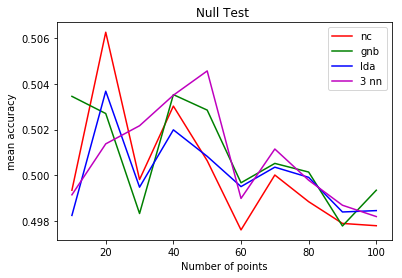

In [32]:
plt.figure()
plt.plot(num_points,mean_accuracy_null_nc, color = 'r')
plt.plot(num_points,mean_accuracy_null_nb, color = 'g')
plt.plot(num_points,mean_accuracy_null_lda, color = 'b')
plt.plot(num_points,mean_accuracy_null_nn, color = 'm')
plt.legend(['nc','gnb','lda','3 nn'])
plt.title('Null Test ')
plt.xlabel('Number of points')
plt.ylabel('mean accuracy')


Text(0,0.5,'mean accuracy')

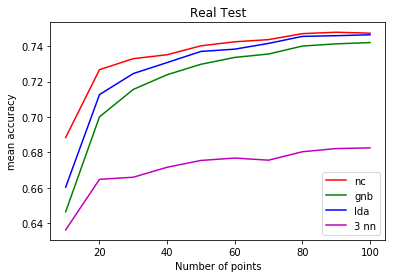

In [33]:
plt.figure()
plt.plot(num_points,mean_accuracy_train_nc, color = 'r')
plt.plot(num_points,mean_accuracy_train_nb, color = 'g')
plt.plot(num_points,mean_accuracy_train_lda, color = 'b')
plt.plot(num_points,mean_accuracy_train_nn, color = 'm')
plt.legend(['nc','gnb','lda','3 nn'])
plt.title('Real Test')
plt.xlabel('Number of points')
plt.ylabel('mean accuracy')


Text(0.5,1,'Nearest centroid classifier')

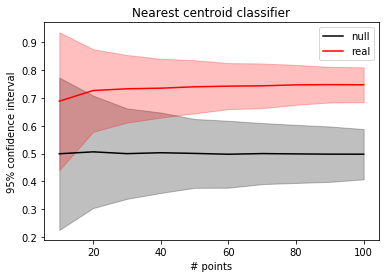

In [34]:
plt.fill_between(num_points, np.add(mean_accuracy_null_nc,np.multiply(2,mean_variance_null_nc)), np.add(mean_accuracy_null_nc,np.multiply(-2,mean_variance_null_nc)), color='k', alpha = 0.25, 
                                  )

plt.fill_between(num_points, np.add(mean_accuracy_train_nc,np.multiply(2,mean_variance_train_nc)), np.add(mean_accuracy_train_nc,np.multiply(-2,mean_variance_train_nc)), color='r', alpha = 0.25, 
                                  )

plt.plot(num_points,mean_accuracy_null_nc, color = 'k')

plt.plot(num_points,mean_accuracy_train_nc, color = 'r')

plt.legend(['null','real'])
plt.xlabel('# points')
plt.ylabel('95% confidence interval')
plt.title('Nearest centroid classifier')



Text(0.5,1,'naive bayes classifier')

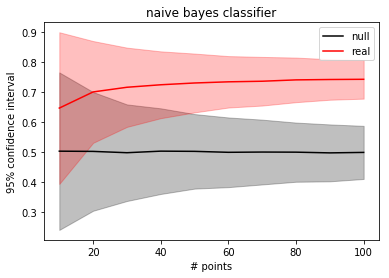

In [35]:
plt.fill_between(num_points, np.add(mean_accuracy_null_nb,np.multiply(2,mean_variance_null_nb)), np.add(mean_accuracy_null_nb,np.multiply(-2,mean_variance_null_nb)), color='k', alpha = 0.25, 
                                  )
plt.fill_between(num_points, np.add(mean_accuracy_train_nb,np.multiply(2,mean_variance_train_nb)), np.add(mean_accuracy_train_nb,np.multiply(-2,mean_variance_train_nb)), color='r', alpha = 0.25, 
                                  )

plt.plot(num_points,mean_accuracy_null_nb, color = 'k')

plt.plot(num_points,mean_accuracy_train_nb, color = 'r')

plt.legend(['null','real'])
plt.xlabel('# points')
plt.ylabel('95% confidence interval')
plt.title('naive bayes classifier')

Text(0.5,1,'lda classifier')

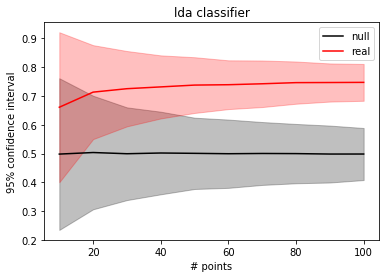

In [36]:
plt.fill_between(num_points, np.add(mean_accuracy_null_lda,np.multiply(2,mean_variance_null_lda)), np.add(mean_accuracy_null_lda,np.multiply(-2,mean_variance_null_lda)), color='k', alpha = 0.25, 
                                  )
plt.fill_between(num_points, np.add(mean_accuracy_train_lda,np.multiply(2,mean_variance_train_lda)), np.add(mean_accuracy_train_lda,np.multiply(-2,mean_variance_train_lda)), color='r', alpha = 0.25, 
                                  )

plt.plot(num_points,mean_accuracy_null_lda, color = 'k')

plt.plot(num_points,mean_accuracy_train_lda, color = 'r')

plt.legend(['null','real'])
plt.xlabel('# points')
plt.ylabel('95% confidence interval')
plt.title('lda classifier')

Text(0.5,1,'3 nn classifier')

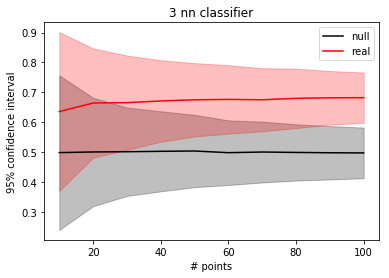

In [37]:
plt.fill_between(num_points, np.add(mean_accuracy_null_nn,np.multiply(2,mean_variance_null_nn)), np.add(mean_accuracy_null_nn,np.multiply(-2,mean_variance_null_nn)), color='k', alpha = 0.25, 
                                  )
plt.fill_between(num_points, np.add(mean_accuracy_train_nn,np.multiply(2,mean_variance_train_nn)), np.add(mean_accuracy_train_nn,np.multiply(-2,mean_variance_train_nn)), color='r', alpha = 0.25, 
                                  )

plt.plot(num_points,mean_accuracy_null_nn, color = 'k')

plt.plot(num_points,mean_accuracy_train_nn, color = 'r')

plt.legend(['null','real'])
plt.xlabel('# points')
plt.ylabel('95% confidence interval')
plt.title('3 nn classifier')

### When we have a small dataset, the classifier fits random noise and give accuracy better than chance on the test set. This is evident from the plots showing a significant overlap between null and real datasets when the number of points is lower. This effect is more pronounced for a complex classifier such as nearest neighbor classifier which has the lowest accuracy on the real data while a simple classifier such as nearest centroid has the highest accuracy. 

### As the number of points increase, the tendency to overfit reduces and the performance improves.If we have a more complex model with a limited amount of training data, then a larger number of free parameters need to be estimated which reduces its accuracy.

### It is also evident from the graph that accuracy increases as we add more training data.

In [ ]:
# #Example Code:

# plt.fill_between(xx, acc_mean_null_nc+2*acc_std_null_nc, acc_mean_null_nc-2*acc_std_null_nc, color='k', alpha = 0.25, label = conf)
# plt.fill_between(xx, acc_mean_test_nc+2*acc_std_test_nc, acc_mean_test_nc-2*acc_std_test_nc, color='r', alpha = 0.25, label = conf)